In [1]:
from IPython.display import display_html
import gptf
import numpy as np
from matplotlib import pyplot as plt
import GPy
from random import randint
 
%matplotlib inline

np.random.seed(10)

# generate data

N=300
X = np.concatenate((np.random.uniform(-3, 5, (N/5,)), np.random.uniform(10, 20, (N/5,)), np.random.uniform(27, 35,(N/5,)), np.random.uniform(40,50, (N/5,)), np.random.uniform( 59,73,(N/5,)) )) #somewhat clumped data

X.sort()
X = X.reshape(N,1)
full_gp = gptf.gpr.GPR(
    gptf.kernels.RBF(variance=10.),
    noise_variance=.25
)

Y = full_gp.compute_prior_samples(X, 1, 1)[0]

Y += np.random.normal(0., np.sqrt(full_gp.likelihood.variance.value),
                      Y.shape)  # add noise
#generate test points

test_points = np.linspace(-5, 50, 300).reshape(-1, 1)

warning in stationary: failed to import cython module: falling back to numpy


In [2]:
def cluster_function(data, nr_points_per_cluster, *centroids):
    # cluster first around the centroids
    #data['X'] is np.array
    N = data['X'].size
    nr_clusters = N/nr_points_per_cluster
    all_distances = np.array([np.linalg.norm(point-centroid) for point in data['X'] for centroid in centroids]).reshape(len(centroids), N)
    clusters_around_centroids = {centroid_index: filter(lambda training_point_index: np.argmin(all_distances[:,training_point_index]) == centroid_index, range(N)) for centroid_index in range(len(centroids))}
    indexes_for_reclustering = {centroid_index: [randint(0, nr_clusters-1) for p in range(len(clusters_around_centroids[centroid_index]))] for centroid_index in range(len(centroids))}
    whole_list_of_final_cluster_assignment = []
    whole_list_of_indexes_in_corresponding_order =[]
    for centroid_index  in range(len(centroids)):
        whole_list_of_final_cluster_assignment = whole_list_of_final_cluster_assignment + indexes_for_reclustering[centroid_index]
        whole_list_of_indexes_in_corresponding_order = whole_list_of_indexes_in_corresponding_order + clusters_around_centroids[centroid_index] 
    
    resulting_list_of_clustered_data = [{'X': np.array([data['X'].reshape(data['X'].size,)[z]  for z in [whole_list_of_indexes_in_corresponding_order[y] for y in filter(lambda x: whole_list_of_final_cluster_assignment[x] == cluster_index, range(N))]]).reshape(-1,1), 'Y': np.array([data['Y'].reshape(data['Y'].size,)[z]  for z in [whole_list_of_indexes_in_corresponding_order[y] for y in filter(lambda x: whole_list_of_final_cluster_assignment[x] == cluster_index, range(N))]]).reshape(-1,1)}  for cluster_index in range(nr_clusters)]
    
    return resulting_list_of_clustered_data

In [3]:
def plot_posterior_mean_var_against_full_gp(axis, mean, var):
    axis.fill_between(test_points[:,0], 
                      full_gp_mean + 2*full_gp_sigma,
                      full_gp_mean - 2*full_gp_sigma,
                      color='#cccccc', linewidth=.0)
    axis.plot(X, Y, 'k.')
    mean, var = mean[:, 0], var[:, 0]
    sigma = np.sqrt(var)
    axis.plot(test_points[:, 0], mean, 'r-',
              test_points[:, 0], mean + 2*sigma, 'r--',
              test_points[:, 0], mean - 2*sigma, 'r--')
    

In [4]:
def compute_bcm_prediction(X, Y, experts, test_points):
    
    bcm = gptf.distributed.BCMReduction(experts)
    bcm_mean, bcm_var = bcm.compute_posterior_mean_var(X, Y, test_points)
    return bcm_mean, bcm_var
    
    

def compute_ind_points_bcm_prediction(X,Y,nr_ind_points, experts, test_points):
    k = GPy.kern.RBF(input_dim=1, variance = 10)
    noise_variance=.25
    m  = GPy.models.SparseGPRegression(X,Y, num_inducing = nr_ind_points)
    m.Gaussian_noise.variance = noise_variance
    m.optimize(messages = False)
    data = {'X': X, 'Y':Y}
    nr_points_per_cluster = X.size/len(experts)
    cluster_centroids = m.inducing_inputs
    clustered_data = cluster_function(data,nr_points_per_cluster, *cluster_centroids) #list of dictionaries, each containing
    X_clustered = []
    Y_clustered =[]
    for i in range(len(clustered_data)):
        X_clustered = X_clustered + clustered_data[i]['X'].tolist()
        Y_clustered = Y_clustered + clustered_data[i]['Y'].tolist()
    X_clustered = np.array(X_clustered).reshape(-1,1)
    Y_clustered = np.array(Y_clustered).reshape(-1,1)
    bcm_modif = gptf.distributed.BCMReduction(experts)
    bcm_modif_mean, bcm_modif_var = bcm_modif.compute_posterior_mean_var(X_clustered, Y_clustered, test_points)
    return bcm_modif_mean, bcm_modif_var
    
    

In [5]:
ind_points_number_range = [5,10,20,50,100]
nr_experts_range = [60,30,15,6,3]
#ind_points_number_range = [5]
#nr_experts_range = [60]
results_bcm = {}
results_ind_bcm ={}
bcm_time = {}
bcm_ind_time = {}
import time



for current_nr_ind_points in ind_points_number_range:
    for current_nr_experts in nr_experts_range:
        template_expert = gptf.gpr.GPR(gptf.kernels.RBF())
        template_expert.kernel.variance = full_gp.kernel.variance.value
        template_expert.kernel.lengthscales = full_gp.kernel.lengthscales.value
        template_expert.likelihood.variance = full_gp.likelihood.variance.value
        experts = [template_expert] * current_nr_experts
        start_time = time.time()
        m,s = compute_bcm_prediction(X, Y, experts, test_points)
        duration = time.time() - start_time
        results_bcm[(current_nr_experts, current_nr_ind_points)] = (m,s)
        bcm_time[(current_nr_experts, current_nr_ind_points)] = duration
        start_time = time.time()
        m1,s1 = compute_ind_points_bcm_prediction(X,Y,current_nr_ind_points, experts, test_points)
        duration = time.time() - start_time
        bcm_ind_time[(current_nr_experts, current_nr_ind_points)] = duration
        results_ind_bcm[(current_nr_experts, current_nr_ind_points)] = (m1,s1)

        

In [12]:
start_time = time.time()
full_gp.optimize(X, Y, disp=False)
full_gp_mean, full_gp_var =\
full_gp.compute_posterior_mean_var(X, Y, test_points)
duration_full_gp = time.time()-start_time
full_gp_mean = full_gp_mean[:, 0]
full_gp_var = full_gp_var[:, 0]
full_gp_sigma = np.sqrt(full_gp_var)


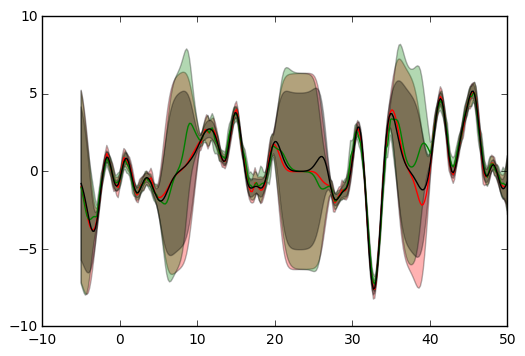

In [13]:
current_nr_ind_points = 5
current_nr_points_per_cluster = 5
current_nr_experts = N/current_nr_points_per_cluster
#print current_nr_ind_points
#print current_nr_points_per_cluster
#print current_nr_experts

plt.plot(test_points,results_bcm[(current_nr_experts,current_nr_ind_points)][0],'r')
plt.fill_between(test_points.reshape(-1,), results_bcm[(current_nr_experts,current_nr_ind_points)][0].reshape(-1,) - 2*np.sqrt(results_bcm[(current_nr_experts,current_nr_ind_points)][1]).reshape(-1,), results_bcm[(current_nr_experts,current_nr_ind_points)][0].reshape(-1,) + 2*np.sqrt(results_bcm[(current_nr_experts,current_nr_ind_points)][1]).reshape(-1,), facecolor = 'red', alpha = 0.3)

plt.plot(test_points,results_ind_bcm[(current_nr_experts,current_nr_ind_points)][0],'g')
plt.fill_between(test_points.reshape(-1,), results_ind_bcm[(current_nr_experts,current_nr_ind_points)][0].reshape(-1,) - 2*np.sqrt(results_ind_bcm[(current_nr_experts,current_nr_ind_points)][1]).reshape(-1,), results_ind_bcm[(current_nr_experts,current_nr_ind_points)][0].reshape(-1,) + 2*np.sqrt(results_ind_bcm[(current_nr_experts,current_nr_ind_points)][1]).reshape(-1,), facecolor = 'green', alpha = 0.3)

plt.plot(test_points, full_gp_mean,'k')
plt.fill_between(test_points.reshape(-1,),full_gp_mean + 2*full_gp_sigma,full_gp_mean - 2*full_gp_sigma, facecolor = 'black', alpha = 0.3)

In [18]:

def plot_comparison_of_bcm_and_ind_bcm_with_full_gp(nr_experts, nr_ind_points_range):
    f= plt.figure()
    for i in range(len(nr_ind_points_range)):
        current_nr_ind_points = nr_ind_points_range[i]
        f.add_subplot(1, len(nr_ind_points_range),i)
        plt.plot(test_points,results_bcm[(nr_experts,current_nr_ind_points)][0],'r')
        plt.fill_between(test_points.reshape(-1,), results_bcm[(nr_experts,current_nr_ind_points)][0].reshape(-1,) - 2*np.sqrt(results_bcm[(nr_experts,current_nr_ind_points)][1]).reshape(-1,), results_bcm[(nr_experts,current_nr_ind_points)][0].reshape(-1,) + 2*np.sqrt(results_bcm[(nr_experts,current_nr_ind_points)][1]).reshape(-1,), facecolor = 'red', alpha = 0.3)
        plt.plot(test_points,results_ind_bcm[(current_nr_experts,current_nr_ind_points)][0],'g')
        plt.fill_between(test_points.reshape(-1,), results_ind_bcm[(nr_experts,current_nr_ind_points)][0].reshape(-1,) - 2*np.sqrt(results_ind_bcm[(nr_experts,current_nr_ind_points)][1]).reshape(-1,), results_ind_bcm[(nr_experts,current_nr_ind_points)][0].reshape(-1,) + 2*np.sqrt(results_ind_bcm[(nr_experts,current_nr_ind_points)][1]).reshape(-1,), facecolor = 'green', alpha = 0.3)
        plt.plot(test_points, full_gp_mean,'k')
        plt.fill_between(test_points.reshape(-1,),full_gp_mean + 2*full_gp_sigma,full_gp_mean - 2*full_gp_sigma, facecolor = 'black', alpha = 0.3)

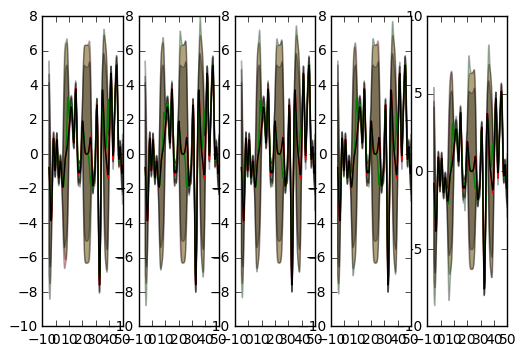

In [20]:
plot_comparison_of_bcm_and_ind_bcm_with_full_gp(3, [5,10, 20, 50, 100])

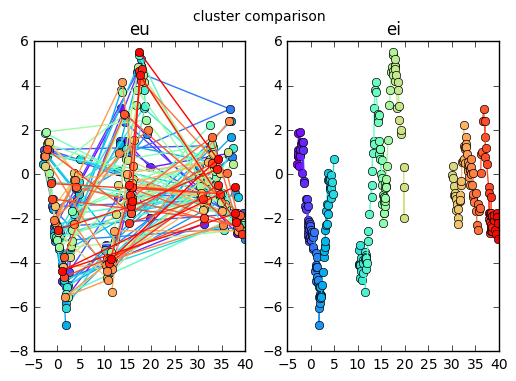

In [4]:
import tensorflow as tf
from matplotlib.pyplot import cm
sess = tf.InteractiveSession()
plot_comp_fig, (plot_comp_axes_cluster_eu,plot_comp_axes_cluster_ei)  = plt.subplots(1,2)
plot_comp_axes_cluster_eu.set_title('eu')
plot_comp_axes_cluster_ei.set_title('ei')

def plot_clusters(experts_used, axes_to_plot, data_X, data_Y):
    nr_clusters = len(experts_used.children)
    chunks = experts_used._get_chunks(data_X,data_Y)
    color=iter(cm.rainbow(np.linspace(0,1,nr_clusters)))
    for child, current_X_chunk, current_Y_chunk in chunks:
        c= next(color)
        axes_to_plot.plot(current_X_chunk.eval(),current_Y_chunk.eval(),c=c, marker='o')
    
plot_clusters(bcm,plot_comp_axes_cluster_ei, X,Y)
plot_clusters(bcm_modif,plot_comp_axes_cluster_eu, X_clustered, Y_clustered)
plot_comp_fig.suptitle('cluster comparison')
plt.draw()
